# Map BOA DAta

all WeatherCubes: 

In [1]:
# read in libraries, including
# AWS python library, boto3
%matplotlib inline 
# moved up
import boto3
from boto3.dynamodb.conditions import Key, Attr
# pandas, for data analysis
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
#plotting 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')
import scipy.stats
import datetime
# Get the service resource.
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('BaltimoreOpenAir2017')

def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    #r = np.corrcoef(x[ind], y[ind])[0,1]
    r,p = scipy.stats.pearsonr(x[ind], y[ind])
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r= %.2f'%r, xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p= %.2f'%p, xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')
# read in metadata
meta = pd.read_csv('data/BaltimoreOpenAir2017_results.csv').set_index('id').drop(28)

In [2]:
meta.index.unique()

array([ 4,  5,  6,  7,  3, 15, 16, 17, 10, 11, 12, 13, 14, 18, 28, 29, 30,
       31, 24, 19, 23, 21, 26, 32, 33, 34, 35, 38, 39, 36, 37, 40, 22, 20,
       25, 27, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [2]:
# read in the MDE data 
#### import MDE data 
#### note that this is not callibrated!!
mde = pd.read_csv('data/HU_minutedata.csv', header = 0,
                   #nrows = 10,
                   skipfooter=10,
                   parse_dates={'datetime': ['Date', 'Time']},
                   ).drop(0)
for col in [u'O3', u'SO2t(trace)', u'RH', u'Temp_10m', u'NO2(NOx)', 'Wind Speed V', 'BP']: 
    mde[col] = pd.to_numeric(mde[col], errors = 'coerce')
    mde[col] = mde[col].dropna()
if type(mde['datetime'].iloc[0])!= pd.tslib.Timestamp: 
    print('time is not timestamp, need to convert')
    mde.index = [pd.datetime.strptime(x, '%m/%d/%Y %I:%M %p') for x in mde['datetime'].values]
else:
    mde = mde.set_index('datetime', drop = False)
mde.head()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.


,datetime,O3,SO2t(trace),Wind Speed V,Wind Dir V,RH,Temp_10m,BP,NO2(NOx)
datetime,,,,,,,,,
2017-09-07 00:01:00,2017-09-07 00:01:00,12.0,0.0,0.5,330,93.0,57.0,1005.9,5.7
2017-09-07 00:02:00,2017-09-07 00:02:00,13.0,0.0,0.4,174,93.0,57.0,1005.9,5.8
2017-09-07 00:03:00,2017-09-07 00:03:00,11.0,0.0,0.7,200,93.0,57.0,1005.9,5.9
2017-09-07 00:04:00,2017-09-07 00:04:00,10.0,0.0,0.7,185,93.0,57.0,1005.9,5.9
2017-09-07 00:05:00,2017-09-07 00:05:00,10.0,0.0,0.8,189,93.0,57.0,1005.9,5.9


In [130]:
# read in sensor data 

ids = meta.index.unique()
o3df = pd.DataFrame()
so2df = pd.DataFrame()
h2sdf = pd.DataFrame()
no2df = pd.DataFrame()

o3stddf = pd.DataFrame()
for sel_id in ids : 
    try: 
        #sel_id = 10
        m_o3 = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
        m_no2 = float(meta.loc[sel_id]['qr_no2'].dropna().values[0][28:])
        m_h2s = float(meta.loc[sel_id]['qr_h2s'].dropna().values[0][28:])
        m_so2= float(meta.loc[sel_id]['qr_so2'].dropna().values[0][28:])

        response = table.query(
                    KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
                )
        df = pd.DataFrame(response['Items'])    
        ## convert post timestamp to datetime
        df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
        # read in batteryAV to get the time, it's contained within a nested vector
        df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

        ## clean data: eliminate rows where MonthDay is not numeric
        df = df[pd.to_numeric(df['MonthDay'], errors='coerce').notnull()]
        for sel_var in ['O3_avg', 'O3_std', 'NO2_avg', 'NO2_std', 'SO2_avg', 'SO2_std','H2S_avg', 'H2S_std'] : 
            df[sel_var] = df[sel_var][pd.to_numeric(df[sel_var], errors='coerce').notnull()].astype(float)

    #     df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']]#.astype(float)#.multiply(0.01)#* m_o3)
    #     df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']]#.astype(float)#.multiply(0.01)#*m_no2)
    #     df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']]#.astype(float)#.multiply(0.01)#* m_so2)
    #     df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']]#.astype(float)#.multiply(0.01)#* m_h2s)

        # set up time index 
        date_index = []
        for date in df[['MonthDay', 'HourMinute']].values : 
            try: 
                if date[0] == '32767' : 
                    date_index.append(np.nan)
                elif date[0] == '0' : 
                    date_index.append(np.nan)
                else:
                    date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
            except ValueError:  
                date_index.append(np.nan)

        df['date_index'] = date_index
        df.index = pd.DatetimeIndex(date_index, freq = '15Min')
        df = df.loc['2017-09-07':]
        #o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))
        
        # create data frames
        o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})
        o3stddf[sel_id] = df['O3_std'].resample('15Min').mean().rename(columns={"O3_std": sel_id})
        so2df[sel_id] = df['SO2_avg'].resample('15Min').mean().rename(columns={"SO2_avg": sel_id})
        h2sdf[sel_id] = df['H2S_avg'].resample('15Min').mean().rename(columns={"H2S_avg": sel_id})
        no2df[sel_id] = df['NO2_avg'].resample('15Min').mean().rename(columns={"NO2_avg": sel_id})
    except : 
        o3df[sel_id]  = np.nan
        o3stddf[sel_id] = np.nan
        so2df[sel_id] = np.nan
        h2sdf[sel_id] = np.nan
        no2df[sel_id] = np.nan
        
o3df.to_csv('data/o3_all_%s.csv'%str(datetime.datetime.now()))
no2df.to_csv('data/no2_all_%s.csv'%str(datetime.datetime.now()))
so2df.to_csv('data/so2_all_%s.csv'%str(datetime.datetime.now()))
h2sdf.to_csv('data/h2s_all_%s.csv'%str(datetime.datetime.now()))

In [9]:
ls data/*.csv

data/BaltimoreOpenAir2017_results.csv
data/HU_minutedata.csv
data/h2s_all_2017-11-27 15:27:37.615045.csv
data/no2_all_2017-11-27 15:27:37.317336.csv
data/o3_all_2017-11-27 15:27:37.137660.csv
data/so2_all_2017-11-27 15:27:37.466745.csv


In [30]:
o3df = pd.read_csv('data/o3_all_2017-11-27 15:27:37.137660.csv').set_index('Unnamed: 0')
o3df.index = o3df.index.to_datetime()
o3df.columns =o3df.columns.astype(int)

In [31]:
# clean data: for monitors deployed before Sept. 25, divide by 100
old_ids = meta[(pd.to_datetime(meta.install_time) < '2017-09-25 13:45:00')].index
# for monitors deployed after (+ Turner Station, 40, 32, 39), don't 
updated_ids = meta[(pd.to_datetime(meta.install_time) > '2017-09-25 13:45:00')].index.append(meta[meta.notes.str.contains('Larry')==True].index)

In [261]:
# Now we callibrate!
o3df_cal = o3df.resample('H').mean().copy()
o3_thresh = 100

for sel_id in old_ids: 
    try: 
        m_o3 = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
    except AttributeError: 
        m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    o3df_cal[sel_id] = (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])/m_o3
for sel_id in updated_ids : 
    try: 
        m_o3 = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
    except AttributeError: 
        m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    o3df_cal[sel_id] = (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])/m_o3

# remove columns with all nans   
o3df_cal = o3df_cal.dropna(axis=1, how = 'all')
# remove data points outside of -500,500
o3df_cal[np.abs(o3df_cal) > 300] = np.nan
# subtract 6am data (ie, assume that 6am data is ~0ppb)
o3df_cal = o3df_cal.subtract(o3df_cal[o3df_cal.index.hour ==6].mean())
# remove data sets that don't have standard deviations above 5 ppb 
# (we could be off by factor of 2, so keeping these )
o3df_cal = o3df_cal.drop(o3df_cal.std()[o3df_cal.std()<6].index, axis=1)

In [11]:
o3df_cal = pd.read_csv('data/callibrated.csv').set_index('Unnamed: 0')
o3df_cal.index = pd.to_datetime(o3df_cal.index)

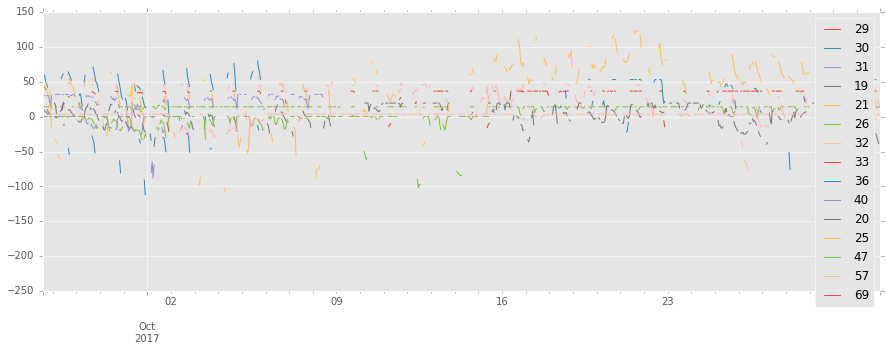

In [266]:
o3df_cal.plot(figsize = [15,5])

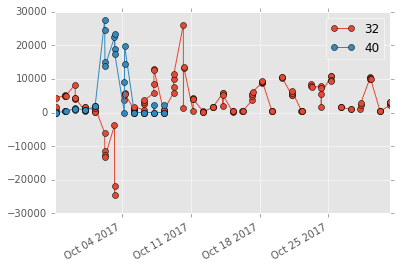

In [273]:
o3df[turner_station][o3df.index.hour ==6].plot(style ='-o')

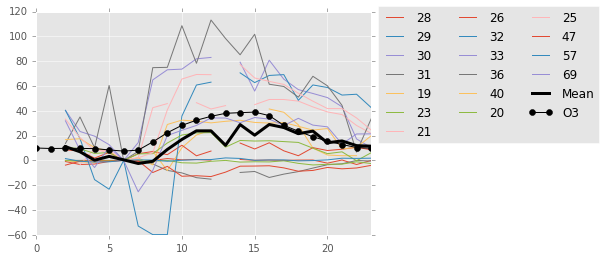

In [34]:
o3df_cal.groupby(o3df_cal.index.hour).mean().plot()
o3df_cal.mean(axis=1).groupby(o3df_cal.index.hour).mean().plot(linewidth = 3, color = 'k', label = 'Mean')
mde['O3'].groupby(mde.index.hour).mean().plot(color = 'k', style = '-o')
plt.legend(bbox_to_anchor=(1.7, 1.05), ncol = 3)

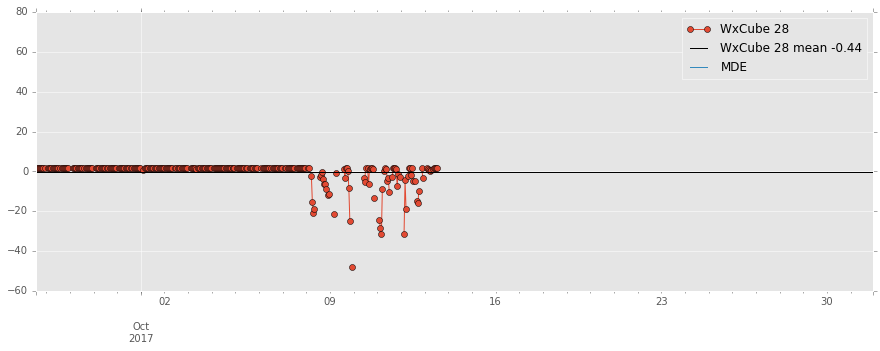

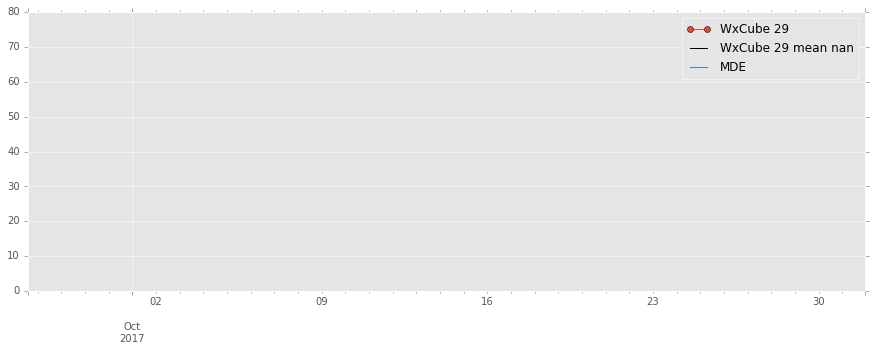

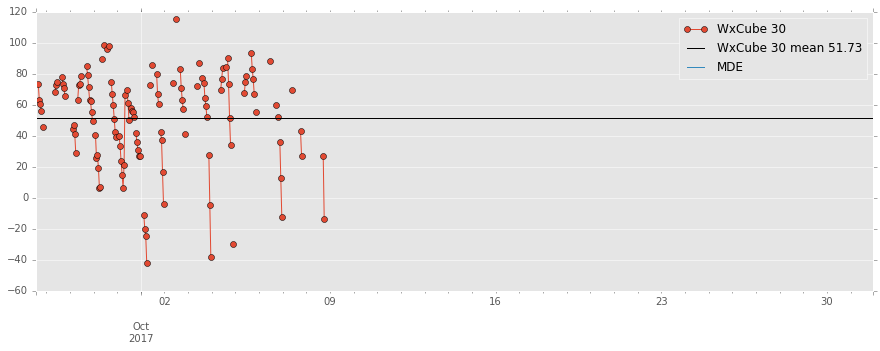

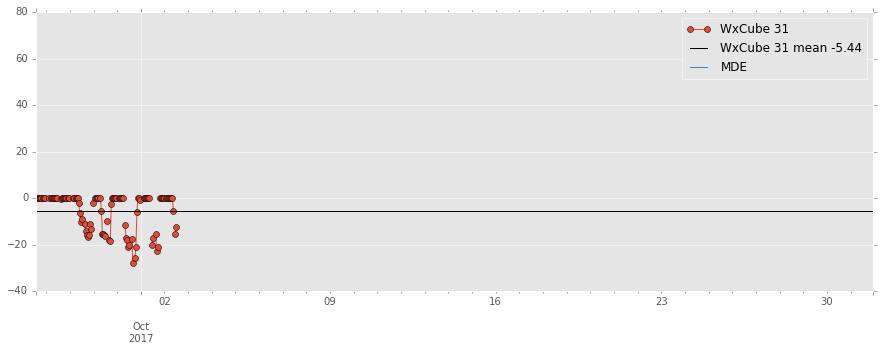

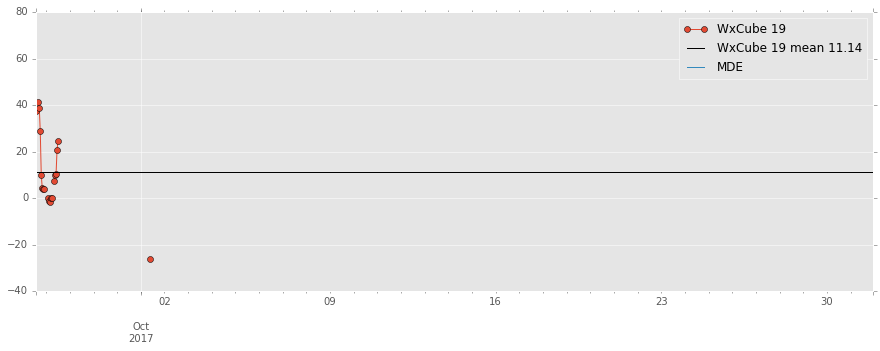

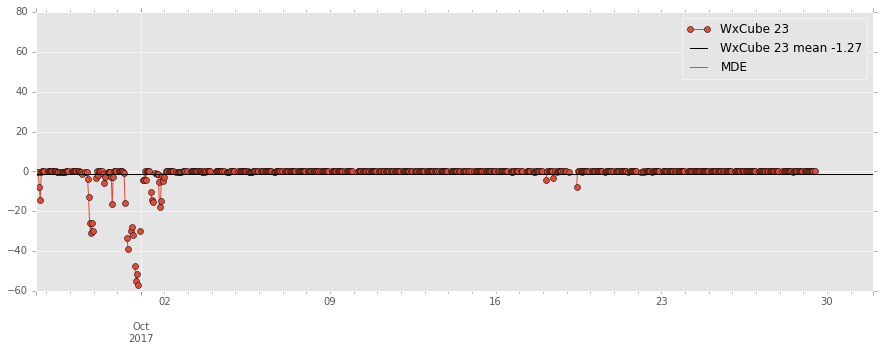

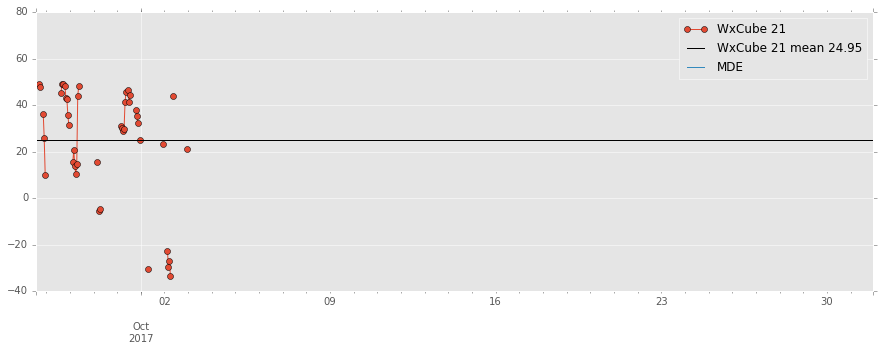

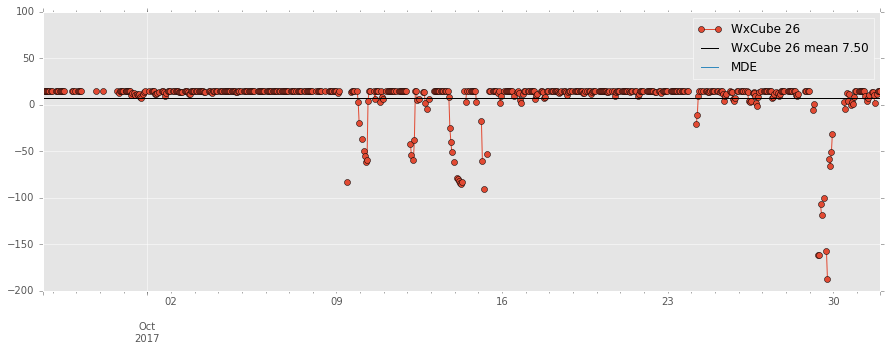

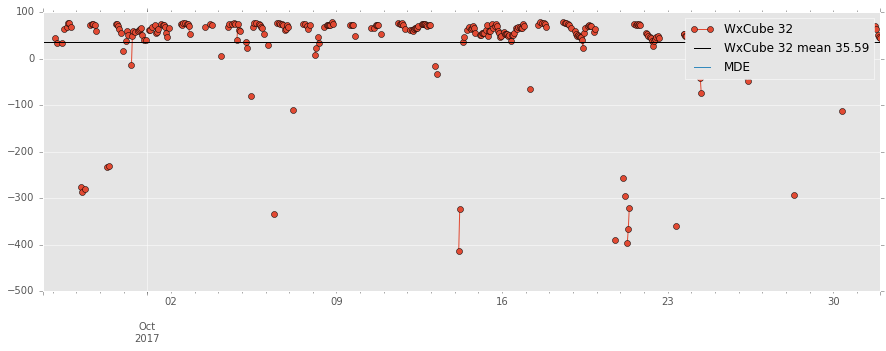

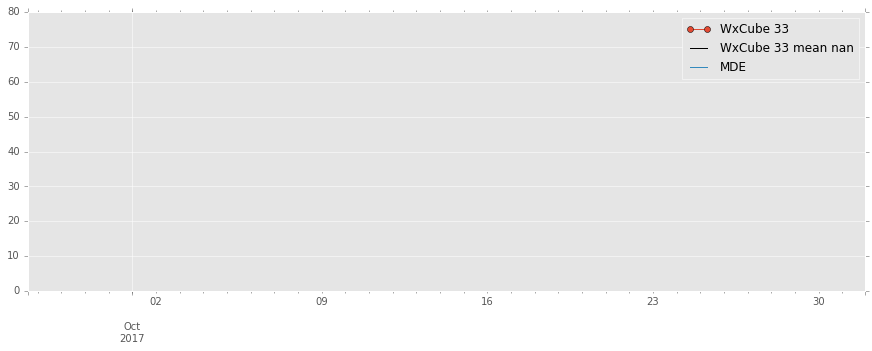

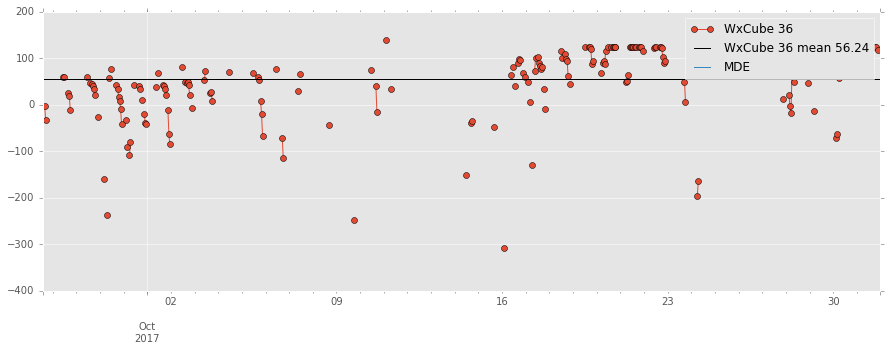

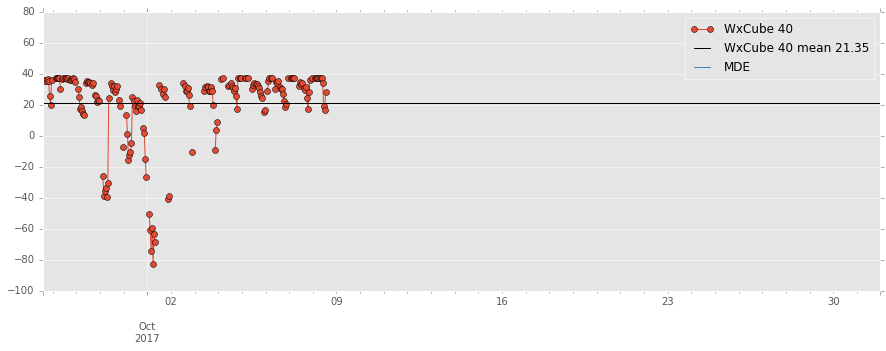

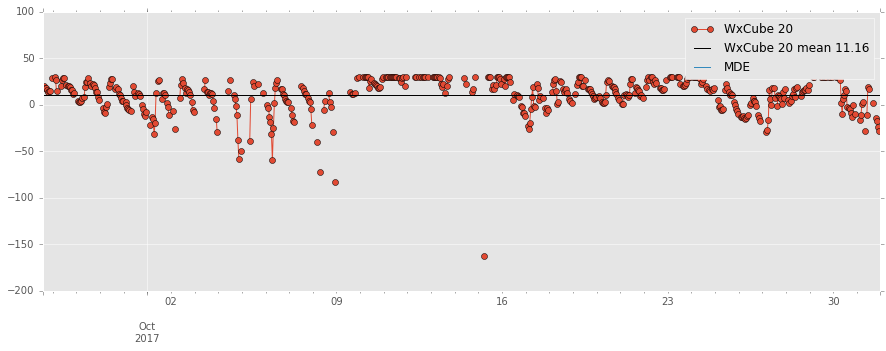

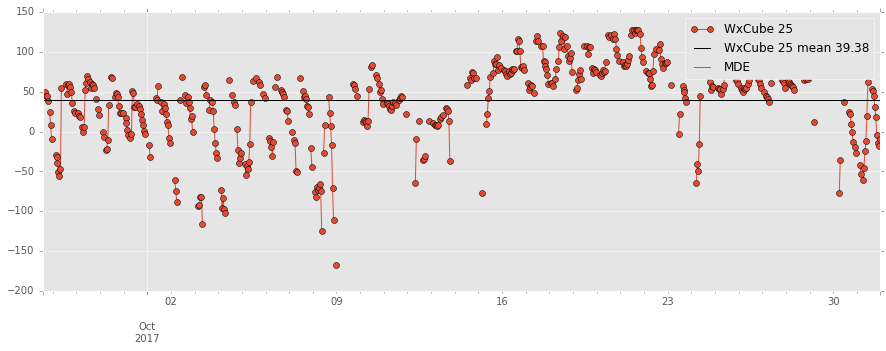

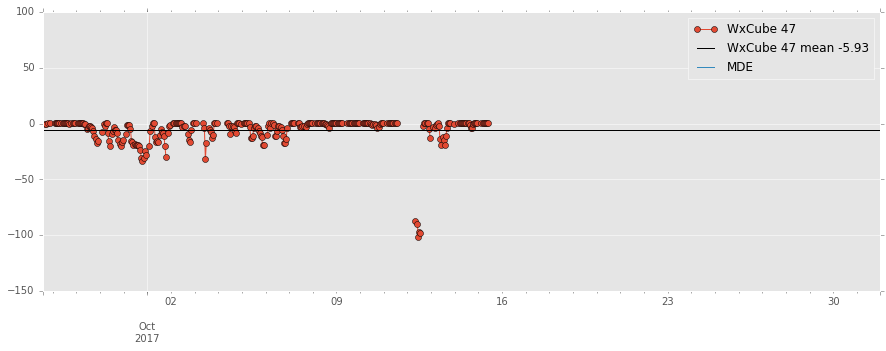

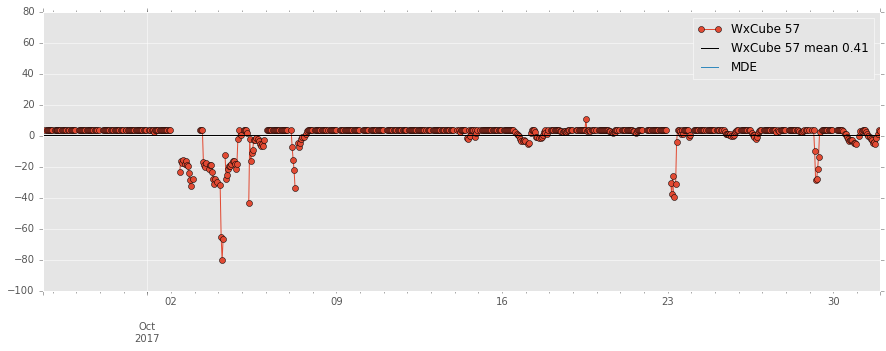

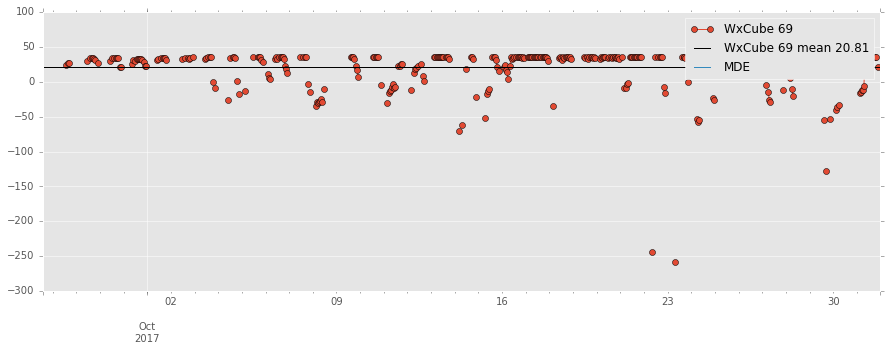

In [35]:
for sel_id in o3df_cal.columns: 
    try: 
#         y =  (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])
#         m = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
#         adjusted = y/m
        plt.figure(figsize = [15,5])
        o3df_cal[sel_id].plot(style ='-o')
        plt.axhline(o3df_cal[sel_id].mean(), color = 'k')
        plt.plot(mde['O3'].resample('H').mean(),label = 'MDE')
        plt.legend(['WxCube %s'%sel_id,'WxCube %s mean %2.2f'%(sel_id, o3df_cal[sel_id].mean()), 'MDE'])
    except TypeError: 
        print('skipping %s'%sel_id)

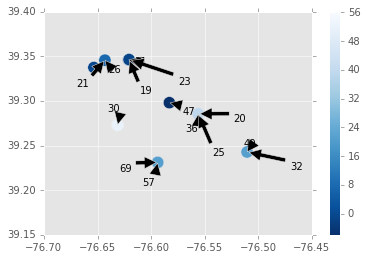

In [196]:
colors = o3df_cal.mean().dropna()
lon = meta['Location:Longitude'].dropna().loc[colors.index].iloc[1:]
lat = meta['Location:Latitude'].dropna().loc[colors.index].iloc[1:]
colors = o3df_cal.mean()
plt.scatter(lon, 
            lat, c = colors[lat.index], s = 150,
            cmap = plt.cm.Blues_r, 
           )
for sel_id in lat.index[1:]: 
# #     plt.text(lon[sel_id]- (np.random.rand(1)-.5)*0.1, 
# #              lat[sel_id]+ (np.random.rand(1)-.5)*0.1,
# #              str(sel_id), 
# #             horizontalalignment='right',
# #             verticalalignment='center', )
    plt.annotate(str(sel_id), xy = (lon[sel_id], lat[sel_id]), 
                 xytext= (lon[sel_id]- (np.random.rand(1)-.5)*0.1,lat[sel_id]+ (np.random.rand(1)-.5)*0.1), 
                xycoords='data', 
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.colorbar()

In [309]:
o3df_cal.to_csv('data/callibrated.csv')

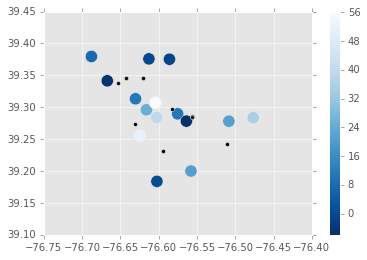

In [224]:
plt.scatter(lon- (np.random.rand(15)-.5)*0.1,
            lat+ (np.random.rand(15)-.5)*0.1, 
           c = colors[lat.index], s = 150,cmap = plt.cm.Blues_r, 
           )
plt.colorbar()

plt.scatter(lon,lat,s = 15,  c = 'k', )

In [ ]:
# make a prettier map
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Mercator())
lon = meta['Location:Longitude'].loc[o3df_cal.columns].dropna()
lat = meta['Location:Latitude'].loc[o3df_cal.columns].dropna()
colors = o3df_cal.mean()

plt.scatter(lon, lat, s=150, c=colors, 
            alpha=1, transform=ccrs.Geodetic(),cmap = plt.cm.Blues,)                # Plot
for sel_id in colors.dropna().index: 
    plt.text(meta['Location:Longitude'].loc[sel_id].dropna(), meta['Location:Latitude'].loc[sel_id].dropna(),
             str(sel_id), 
            horizontalalignment='right',
            verticalalignment='center', transform = ccrs.Geodetic())
plt.colorbar()

In [239]:
# Asssess consistency 
turner_station = meta.loc[o3df_cal.columns].loc[meta.loc[o3df_cal.columns].notes.str.contains('Larry')==True].index

(0, 100)

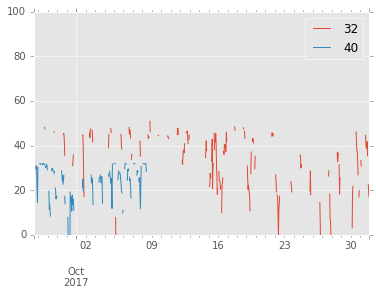

In [269]:
o3df_cal[turner_station].plot('')
plt.ylim([0,100])

(0, 100)

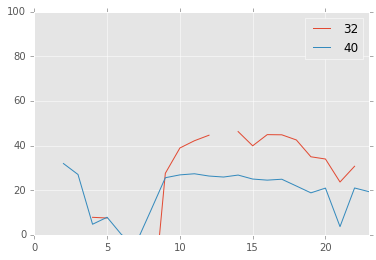

In [268]:
o3df_cal[turner_station][:'2017-10-09'].groupby(o3df_cal[:'2017-10-09'].index.hour).mean().plot()
plt.ylim([0,100])

In [276]:
meta['Location:Longitude'].loc[sel_id]

id
69          NaN
69   -76.593859
Name: Location:Longitude, dtype: float64

In [108]:
sel_id = 19
m_o3 = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
m_no2 = float(meta.loc[sel_id]['qr_no2'].dropna().values[0][28:])
m_h2s = float(meta.loc[sel_id]['qr_h2s'].dropna().values[0][28:])
m_so2= float(meta.loc[sel_id]['qr_so2'].dropna().values[0][28:])

response = table.query(
            KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
        )
df = pd.DataFrame(response['Items'])    
## convert post timestamp to datetime
df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
# read in batteryAV to get the time, it's contained within a nested vector
df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

## clean data: eliminate rows where MonthDay is not numeric
df = df[pd.to_numeric(df['MonthDay'], errors='coerce').notnull()]
for sel_var in ['O3_avg', 'O3_std', 'NO2_avg', 'NO2_std', 'SO2_avg', 'SO2_std','H2S_avg', 'H2S_std'] : 
    df[sel_var] = df[sel_var][pd.to_numeric(df[sel_var], errors='coerce').notnull()].astype(float)

#     df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']]#.astype(float)#.multiply(0.01)#* m_o3)
#     df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']]#.astype(float)#.multiply(0.01)#*m_no2)
#     df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']]#.astype(float)#.multiply(0.01)#* m_so2)
#     df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']]#.astype(float)#.multiply(0.01)#* m_h2s)

# set up time index 
date_index = []
for date in df[['MonthDay', 'HourMinute']].values : 
    try: 
        if date[0] == '32767' : 
            date_index.append(np.nan)
        elif date[0] == '0' : 
            date_index.append(np.nan)
        else:
            date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
    except ValueError:  
        date_index.append(np.nan)

df['date_index'] = date_index
df.index = pd.DatetimeIndex(date_index, freq = '15Min')
df = df.loc['2017-09-07':]
#o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))

# create data frames
o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})

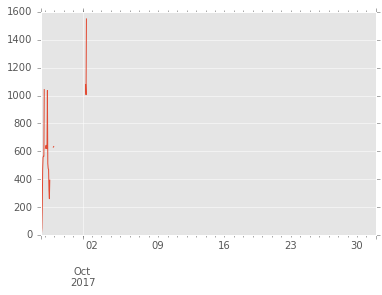

In [101]:
o3df_cal[19].plot()

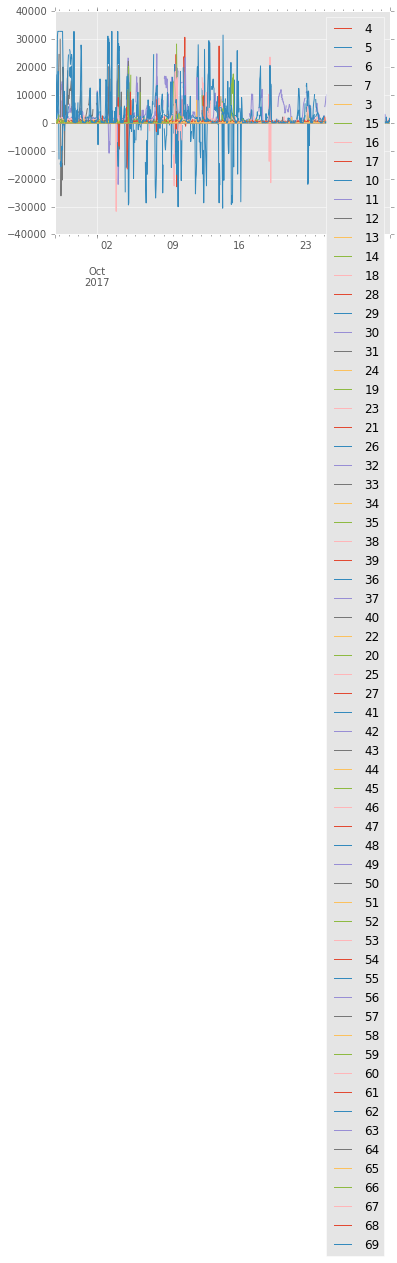

In [103]:
o3df_cal.plot()

In [64]:
o3df.loc[old_ids]

KeyError: "None of [Int64Index([ 4,  5,  6,  7,  3, 15, 16, 17, 10, 11, 12, 13, 14, 18, 28, 29, 30,\n            31, 28, 28, 24, 19, 23, 31, 29, 21, 26, 32, 33, 34, 35, 38, 39, 36,\n            37, 40, 23, 22, 20, 25, 27, 25, 26, 24, 19, 21, 35, 38, 34, 40, 32,\n            39, 33, 30, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,\n            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 52,\n            47, 36, 20, 25, 64, 66, 59],\n           dtype='int64', name=u'id')] are in the [index]"

# Ozone

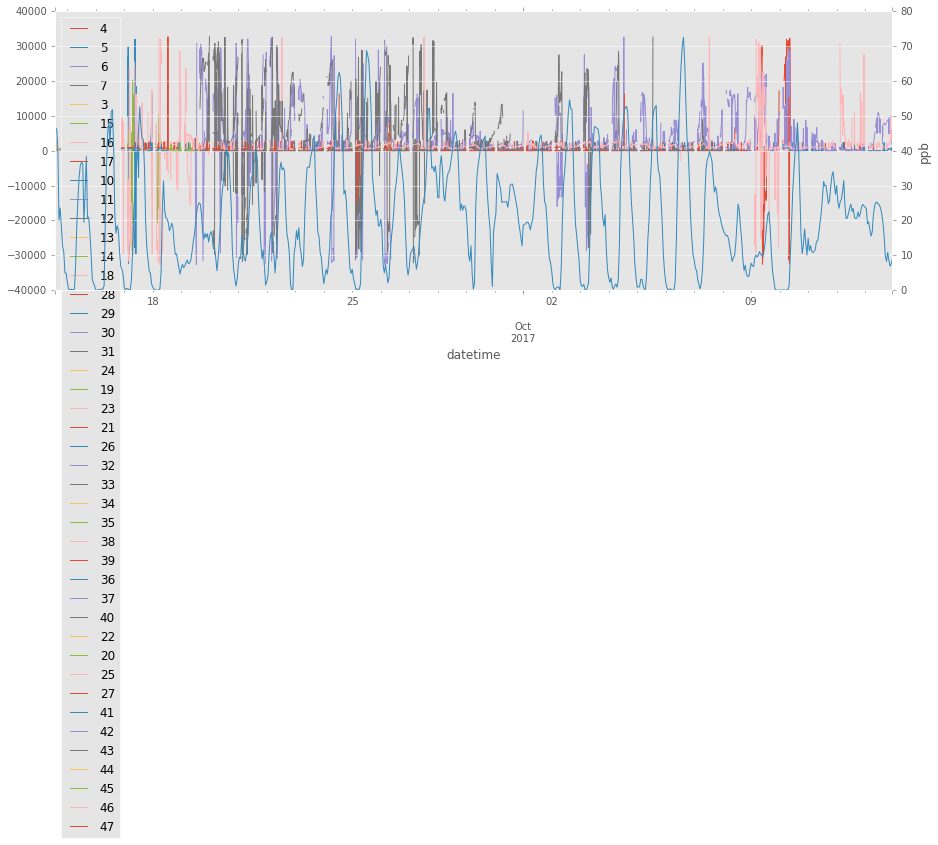

In [12]:
o3df.plot()
mde['O3'][o3df.index[0]: o3df.index[-1]].resample('H').mean().plot(figsize = [15,5], label = 'MDE', secondary_y = True)
plt.ylabel('ppb')

Raw data is very noisy. We should drop points around spikes of data when the variability is high. Also, we still see that the data is cutoff around 50 ppb or so.

skipping 24


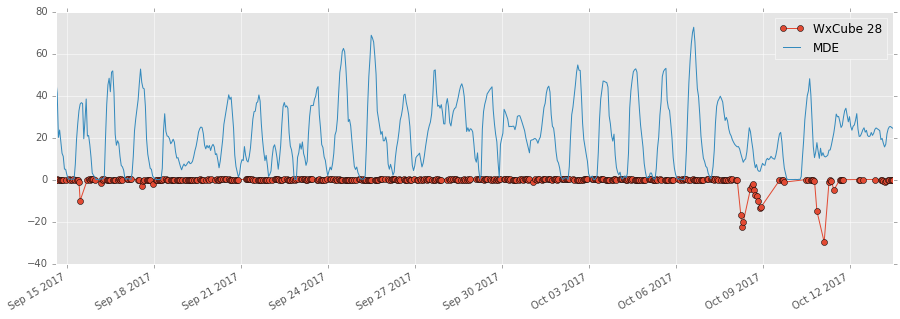

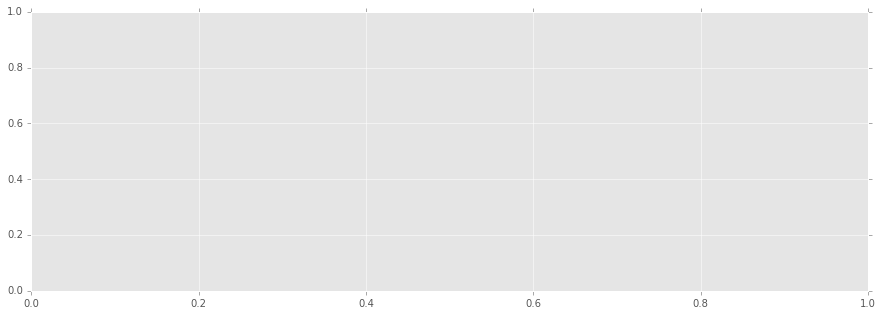

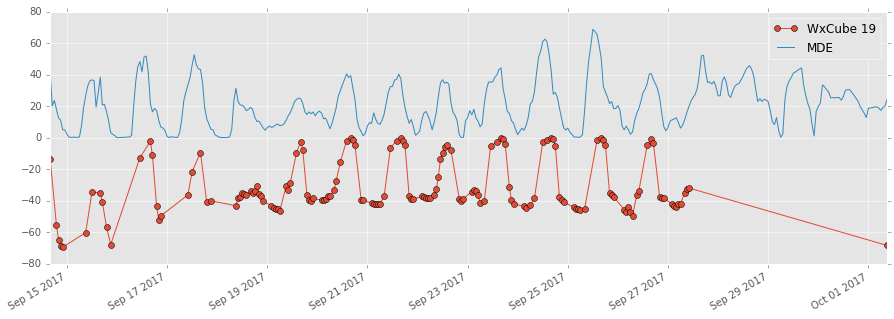

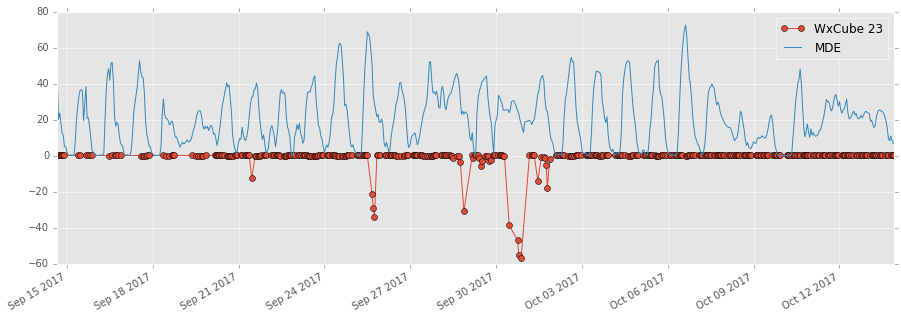

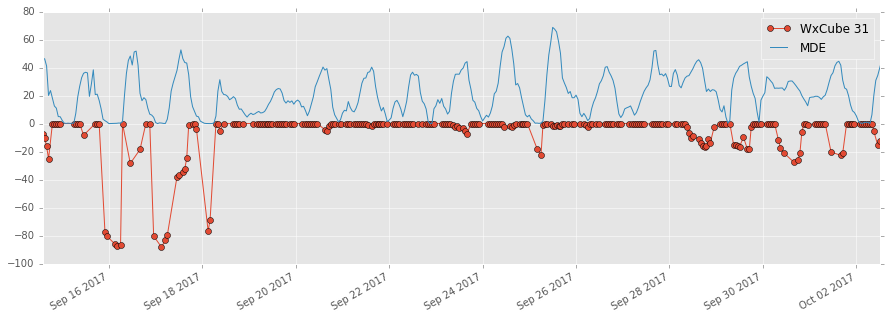

In [12]:
o3_thresh = 50

for sel_id in ids: 
    try: 
        y =  (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])
        m = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
        adjusted = y/m
        plt.figure(figsize = [15,5])
        adjusted.plot(style ='-o')
        plt.plot(mde['O3'].resample('H').mean(),label = 'MDE')
        plt.legend(['WxCube %s'%sel_id, 'MDE'])
    except TypeError: 
        print('skipping %s'%sel_id)

We need to adjust the zero offset on WeatherCube 19. We can do this by matching up the low values of ozone at night. This may introduce a bias in our readings, but gives a good first glance at what ozone looks like in this location. 

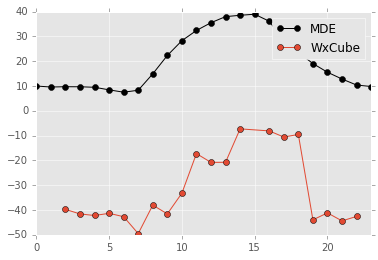

In [13]:
mde['O3'].groupby(mde.index.hour).mean().plot(color = 'k', style = '-o')
sel_id = 19
y =  (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])
m = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
(y/m).groupby(y.index.hour).mean().plot(style = '-o')
plt.legend(['MDE', 'WxCube'])

Rather than computing the ozone value of offset, we'll calculate the ADC value at 6am and subtract off.

In [15]:
o3df[o3df.index.hour==7][sel_id].mean()

1946.142857142857

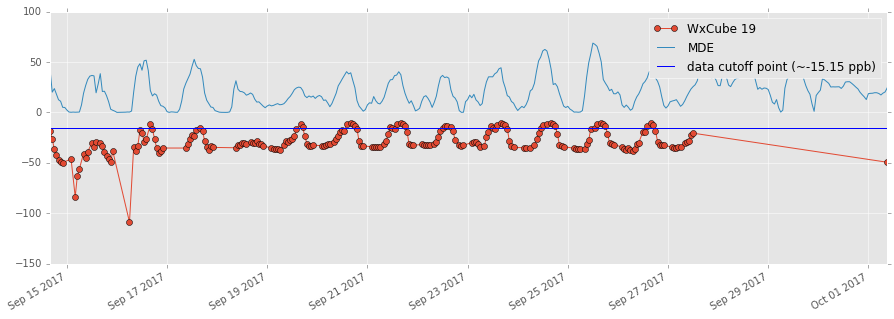

In [17]:
sel_id = 19
o3_thresh = 250
y =  (o3df[sel_id].resample('H').mean()[(o3df[sel_id].resample('H').std()<o3_thresh)])
m = float(meta.loc[sel_id]['qr_ozone'].dropna().values[0][28:])
v_zero = o3df[o3df.index.hour==6][sel_id].mean()
# The "callibrated" version subtracts off the vzero and divides by m
# Note that our value was off by a factor of 1/1.76 when we measured at the station,
# so we adjust by this amount as well
adjusted = 1/1.76 * (y-v_zero)/m

plt.figure(figsize = [15,5])
adjusted.plot(style = '-o')
plt.plot(mde['O3'].resample('H').mean(),label = 'MDE')

max_cutoff = adjusted.groupby(adjusted.index.hour).mean().max()
plt.axhline(max_cutoff)
plt.legend(['WxCube %s'%sel_id, 'MDE', 'data cutoff point (~%2.2f ppb)'%max_cutoff])


# NO2

In [136]:
mde.head()

,datetime,O3,SO2t(trace),Wind Speed V,Wind Dir V,RH,Temp_10m,BP,NO2(NOx)
datetime,,,,,,,,,
2017-09-07 00:01:00,2017-09-07 00:01:00,12.0,0.0,0.5,330,93.0,57.0,1005.9,5.7
2017-09-07 00:02:00,2017-09-07 00:02:00,13.0,0.0,0.4,174,93.0,57.0,1005.9,5.8
2017-09-07 00:03:00,2017-09-07 00:03:00,11.0,0.0,0.7,200,93.0,57.0,1005.9,5.9
2017-09-07 00:04:00,2017-09-07 00:04:00,10.0,0.0,0.7,185,93.0,57.0,1005.9,5.9
2017-09-07 00:05:00,2017-09-07 00:05:00,10.0,0.0,0.8,189,93.0,57.0,1005.9,5.9


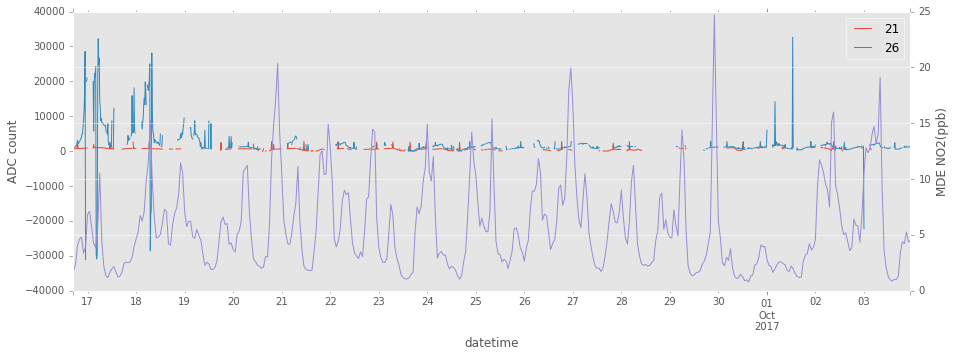

In [138]:
no2df.plot()
plt.ylabel('ADC count')
mde['NO2(NOx)'][o3df.index[0]: o3df.index[-1]].resample('H').mean().plot(figsize = [15,5], label = 'MDE', secondary_y = True)
plt.ylabel('MDE NO2(ppb)')

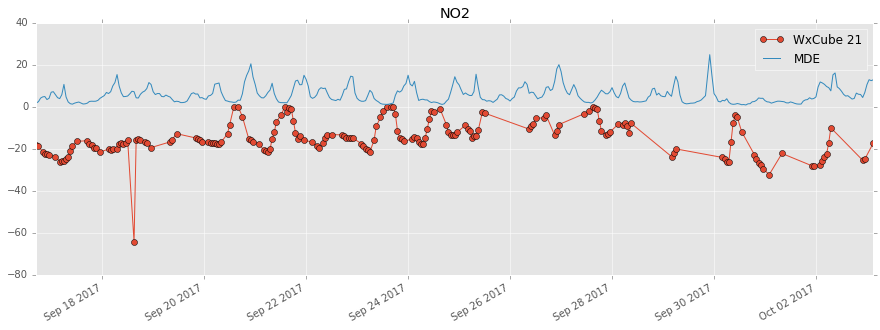

In [142]:
sel_id = 21
no2_thresh = 250
y =  (no2df[sel_id].resample('H').mean()[(no2df[sel_id].resample('H').std()<no2_thresh)])
m = float(meta.loc[sel_id]['qr_no2'].dropna().values[0][28:])
adjusted = y/m
plt.figure(figsize = [15,5])
adjusted.plot(style ='-o')
plt.plot(mde['NO2(NOx)'].resample('H').mean(),label = 'MDE')
plt.legend(['WxCube %s'%sel_id, 'MDE'])
plt.title('NO2')

These values are really low- within the plus or minus 20 ppb that the WeatherCube can sense. We'll give callibration a try, anyways. First, we need to adjust the zero offset on WeatherCube 21. We should do this by matching up zero values of NO2 at night.

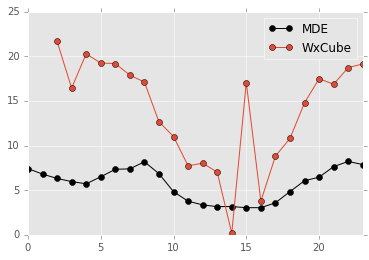

In [145]:
mde['NO2(NOx)'].groupby(mde.index.hour).mean().plot(color = 'k', style = '-o')
sel_id = 21
y =  (no2df[sel_id].resample('H').mean()[(no2df[sel_id].resample('H').std()<no2_thresh)])
m = float(meta.loc[sel_id]['qr_no2'].dropna().values[0][28:])
(-1*y/m).groupby(y.index.hour).mean().plot(style = '-o')
plt.legend(['MDE', 'WxCube'])